# 14 - Données de Panel et Effets Fixes

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

Dans le chapitre précédent, nous avons exploré une configuration très simple de Diff-in-Diff, où nous avions un groupe traité et un groupe de contrôle (la ville de Porto Alegre et Florianópolis, respectivement) et seulement deux périodes, une période pré-intervention et une période post-intervention. Mais que se passerait-il si nous avions plus de périodes ? Ou plus de groupes ? Il s'avère que cette configuration est si courante et puissante pour l'inférence causale qu'elle a son propre nom : les données de panel. Un panel se compose d'observations répétées de la même unité sur plusieurs périodes. Cela se produit fréquemment dans l'évaluation des politiques publiques, où l'on peut suivre les données de plusieurs villes ou États sur plusieurs années. Mais c'est aussi extrêmement courant dans l'industrie, où les entreprises suivent les données des utilisateurs sur plusieurs semaines et mois.

Pour comprendre comment nous pouvons tirer parti de cette structure de données, continuons avec notre exemple de Diff-in-Diff, où nous voulions estimer l'impact de l'installation d'un panneau publicitaire (traitement) dans la ville de Porto Alegre (POA). Nous voulons voir si ce type de stratégie de marketing hors ligne peut augmenter l'utilisation de nos produits d'investissement. Plus précisément, nous voulons savoir de combien les dépôts sur nos comptes d'investissement augmenteraient si nous installions des panneaux publicitaires.

Dans le chapitre précédent, nous avons présenté l'estimateur DiD comme une stratégie d'imputation de ce qui se serait passé à Porto Alegre si nous n'avions pas installé les panneaux publicitaires. Nous avons dit que le résultat contrefactuel $Y_0$ pour Porto Alegre **après l'intervention** (installation d'un panneau publicitaire) pouvait être estimé comme le nombre de dépôts à Porto Alegre **avant l'intervention** plus un facteur de croissance. Ce facteur de croissance a été estimé dans une ville de contrôle, Florianópolis (FLN). Pour récapituler un peu de notation, voici comment nous pouvons estimer ce résultat contrefactuel :

$$
\underbrace{\widehat{Y_0(1)|D=1}}_{\substack{\text{Résultat de POA après l'intervention}} \\ \substack{\text{si aucune intervention n'avait eu lieu}}} 
= \underbrace{Y_0(0)|D=1}_{\substack{\text{Résultat de POA}} \\ \substack{\text{avant l'intervention}}} 
+ \big( \underbrace{Y_0(1)|D=0}_{\substack{\text{Résultat de FLN après}} \\ \substack{\text{l'intervention à POA}}} 
- \underbrace{Y_0(0)|D=0}_{\substack{\text{Résultat de FLN avant}} \\ \substack{\text{l'intervention à POA}}} \big)
$$

où $t$ représente le temps, $D$ représente le traitement, $Y_D(t)$ représente le résultat potentiel pour le traitement $D$ à la période $t$ (par exemple, $Y_0(1)$ est le résultat sous le contrôle à la période 1). Maintenant, si nous prenons ce résultat potentiel imputé, nous pouvons récupérer l'effet du traitement pour POA (ATT) comme suit :

$$
\widehat{ATT} = \underbrace{Y_1(1)|D=1}_{\substack{\text{Résultat de POA} \\ \text{après l'intervention}}} - \widehat{Y_0(1)|D=1}
$$

En d'autres termes, l'effet de l'installation d'un panneau publicitaire à POA est le résultat observé à POA après l'installation du panneau publicitaire moins notre estimation de ce qui se serait passé si nous n'avions pas installé le panneau. Rappelez-vous également que la puissance de DiD provient du fait que l'estimation de ce contrefactuel mentionné ne nécessite que la croissance des dépôts à POA corresponde à la croissance des dépôts à FLN. C'est l'hypothèse clé des tendances parallèles. Nous devrions y consacrer du temps car elle va devenir très importante par la suite.

## Tendances Parallèles

Une façon de voir l'hypothèse des tendances parallèles est de la considérer comme une hypothèse d'indépendance. Si nous nous souvenons des premiers chapitres, l'hypothèse d'indépendance stipule que l'attribution du traitement est indépendante des résultats potentiels :

$$
Y_d \perp  D
$$

Cela signifie que nous ne donnons pas plus de traitement aux unités avec des résultats plus élevés (ce qui provoquerait un biais à la hausse dans l'estimation de l'effet) ou plus faibles (ce qui provoquerait un biais à la baisse). Pour en revenir à notre exemple, supposons que votre directeur marketing décide d'ajouter des panneaux publicitaires uniquement dans les villes qui ont déjà des dépôts très élevés. De cette manière, il ou elle pourra ensuite affirmer que les villes avec des panneaux publicitaires génèrent plus de dépôts, donc bien sûr, la campagne marketing a été un succès. En mettant de côté la discussion morale ici, je pense que vous pouvez voir que cela viole l'hypothèse d'indépendance : nous donnons le traitement aux villes avec un $Y_0$ élevé. De plus, rappelez-vous qu'une extension naturelle de cette hypothèse est l'hypothèse d'indépendance conditionnelle, qui permet aux résultats potentiels d'être dépendants du traitement au départ, mais indépendants une fois que nous conditionnons sur les variables confondantes $X$ :

$$
Y_d \perp D | X
$$

Vous savez déjà tout cela. Mais comment cela se rapporte-t-il à DiD et à l'hypothèse des tendances parallèles ? Si l'hypothèse d'indépendance traditionnelle stipule que l'attribution du traitement ne peut pas être liée **aux niveaux** des résultats potentiels, l'hypothèse des tendances parallèles stipule que l'attribution du traitement ne peut pas être liée **à la croissance** des résultats potentiels au fil du temps. En fait, une façon d'écrire l'hypothèse des tendances parallèles est la suivante :

$$
\big(Y_d(t) - Y_d(t-1) \big)  \perp D
$$

En termes moins mathématiques, cette hypothèse dit qu'il est acceptable d'attribuer le traitement à des unités qui ont un niveau de résultat plus élevé ou plus faible. Ce que nous ne pouvons pas faire, c'est attribuer le traitement à des unités en fonction de la façon dont le résultat évolue. Dans notre exemple de panneaux publicitaires, cela signifie qu'il est acceptable de placer des panneaux publicitaires uniquement dans des villes avec un niveau de dépôts initialement élevé. Ce que nous ne pouvons pas faire, c'est placer des panneaux publicitaires uniquement dans des villes où les dépôts augmentent le plus. Cela a beaucoup de sens si nous nous souvenons que DiD impute la croissance contrefactuelle dans l'unité traitée en fonction de la croissance dans l'unité de contrôle. Si la croissance dans l'unité traitée sous contrôle est différente de celle dans l'unité de contrôle, alors nous avons un problème.


## Contrôler ce que vous ne pouvez pas voir

Les méthodes comme le score de propension, la régression linéaire et l'appariement sont très efficaces pour contrôler les variables confondantes dans les données non aléatoires, mais elles reposent sur une hypothèse clé : l'absence de confusion conditionnelle

$$
(Y_0, Y_1) \perp T | X
$$

En d'autres termes, elles exigent que toutes les variables confondantes soient connues et mesurées, afin que nous puissions les conditionner et rendre le traitement aussi aléatoire que possible. Un problème majeur avec cela est que parfois, nous ne pouvons tout simplement pas mesurer une variable confondante. Par exemple, prenons un problème classique d'économie du travail consistant à déterminer l'impact du mariage sur les revenus des hommes. Il est bien connu en économie que les hommes mariés gagnent plus que les hommes célibataires. Cependant, il n'est pas clair si cette relation est causale ou non. Il se pourrait que les hommes plus éduqués soient à la fois plus susceptibles de se marier et plus susceptibles d'avoir un emploi bien rémunéré, ce qui signifierait que l'éducation est une variable confondante de l'effet du mariage sur les revenus. Pour cette variable confondante, nous pourrions mesurer l'éducation de la personne dans l'étude et effectuer une régression en la contrôlant. Mais une autre variable confondante pourrait être la beauté. Il se pourrait que les hommes plus beaux soient à la fois plus susceptibles de se marier et plus susceptibles d'avoir un emploi bien rémunéré. Malheureusement, la beauté est l'une de ces caractéristiques comme l'intelligence. C'est quelque chose que nous ne pouvons pas très bien mesurer.

Cela nous place dans une situation difficile, car si nous avons des variables confondantes non mesurées, nous avons un biais. Une façon de traiter cela est d'utiliser des variables instrumentales, comme nous l'avons vu auparavant. Mais trouver de bons instruments n'est pas une tâche facile et nécessite beaucoup de créativité. Ici, au lieu de cela, utilisons la structure de nos données de panel.

Nous avons déjà vu comment les données de panel nous permettent de remplacer l'hypothèse d'absence de confusion par l'hypothèse des tendances parallèles. Mais comment cela aide-t-il avec les variables confondantes non mesurées ? Tout d'abord, examinons le graphe causal qui représente cette configuration où nous avons des observations répétées au fil du temps. Ici, nous suivons la même observation sur 4 périodes. Le mariage (le traitement) et le revenu (le résultat) changent au fil du temps. Plus précisément, le mariage est activé (de 0 à 1) aux périodes 3 et 4 et le revenu augmente au cours des mêmes périodes. La beauté, la variable confondante non mesurée, reste la même au fil du temps (une affirmation audacieuse, mais raisonnable si le temps est de quelques années). Alors, comment pouvons-nous savoir que l'augmentation du revenu est due au mariage et non simplement à une augmentation de la beauté confondante ? Et, plus important encore, comment pouvons-nous contrôler cette variable confondante que nous ne pouvons pas voir ?

![img](./data/img/fixed-effects/fe-graph.png)

L'astuce consiste à voir que, en nous concentrant sur une unité et en suivant son évolution au fil du temps, nous contrôlons déjà tout ce qui est fixe dans le temps. Cela inclut toutes les variables confondantes non mesurées mais fixes dans le temps. Dans le graphe ci-dessus, par exemple, nous savons déjà que l'augmentation du revenu au fil du temps ne peut pas être due à une augmentation de la beauté, simplement parce que la beauté reste la même (elle est fixe dans le temps). L'essentiel est que, même si nous ne pouvons pas contrôler la beauté, puisque nous ne pouvons pas la mesurer, nous pouvons toujours utiliser la structure du panel pour que cela ne soit plus un problème.

Une autre façon de voir cela est de penser à ces variables confondantes fixes dans le temps comme à des attributs spécifiques à chaque unité. Cela équivaudrait à ajouter un nœud d'unité intermédiaire à notre graphe causal. Maintenant, remarquez comment le contrôle de l'unité elle-même bloque déjà le chemin de retour entre le résultat et n'importe quelle des variables confondantes non observées mais fixes dans le temps.

![img](./data/img/fixed-effects/control-unit.png)

Réfléchissez-y. Nous ne pouvons pas mesurer des attributs comme la beauté et l'intelligence, mais nous savons que la personne qui les possède est la même personne au fil du temps. La mécanique consistant à effectuer ce contrôle est très simple. Tout ce que nous devons faire est de créer des variables dummies indiquant cette personne et de les ajouter à un modèle linéaire. C'est ce que nous entendons lorsque nous disons que nous pouvons contrôler la personne elle-même : nous ajoutons une variable (dummy dans ce cas) qui dénote cette personne particulière. Lors de l'estimation de l'effet du mariage sur le revenu avec cette dummy de personne dans notre modèle, la régression trouve l'effet du mariage **tout en maintenant la variable de la personne fixe**. L'ajout de cette variable dummy d'unité est ce que nous appelons un modèle à effets fixes.

## Fixed Effects

To make matters more formal, let's first take a look at the data that we have. Following our example, we will try to estimate the effect of marriage on income. Our data contains those 2 variables, `married` and `lwage`, on multiple individuals (`nr`) for multiple years. Notice that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [2]:
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


Généralement, le modèle à effets fixes est défini comme suit :

$$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$$

où $y_{it}$ est le résultat de l'individu $i$ à l'instant $t$, $X_{it}$ est le vecteur des variables observables pour l'individu $i$ à l'instant $t$, et $U_i$ est un ensemble de variables inobservables spécifiques à l'individu $i$. Remarquez que ces variables inobservables ne changent pas au fil du temps, d'où l'absence d'indice temporel. Enfin, $e_{it}$ est le terme d'erreur. Pour l'exemple de l'éducation, $y_{it}$ représente le salaire en logarithme, $X_{it}$ sont les variables observables qui changent avec le temps, comme le mariage et l'expérience, et $U_i$ sont les variables inobservées mais constantes pour chaque individu, comme la beauté et l'intelligence.

### Modèle à Effets Fixes et Régression Linéaire

Rappelez-vous comment j'ai mentionné que l'utilisation des données de panel avec un modèle à effets fixes est aussi simple que d'ajouter une variable dummy pour chaque entité. C'est vrai, mais en pratique, nous ne le faisons généralement pas ainsi. Imaginez un ensemble de données contenant 1 million de clients. Si nous ajoutons une dummy pour chacun d'eux, nous nous retrouverions avec 1 million de colonnes, ce qui n'est probablement pas une bonne idée. À la place, nous utilisons une astuce qui consiste à diviser la régression linéaire en deux modèles distincts. Nous avons déjà vu cela auparavant, mais c'est le bon moment pour le rappeler. Supposons que vous ayez un modèle de régression linéaire avec un ensemble de caractéristiques $X_1$ et un autre ensemble de caractéristiques $X_2$.

$$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$$

où $X_1$ et $X_2$ sont des matrices de caractéristiques (une ligne par caractéristique et une colonne par observation) et $\hat{\beta_1}$ et $\hat{\beta_2}$ sont des vecteurs ligne. Vous pouvez obtenir le même paramètre $\hat{\beta_1}$ en procédant de la manière suivante :

1. Régressiez le résultat $y$ sur le second ensemble de caractéristiques $\hat{y^*} = \hat{\gamma_1} X_2$
2. Régressiez le premier ensemble de caractéristiques sur le second $\hat{X_1} = \hat{\gamma_2} X_2$
3. Obtenez les résidus $\tilde{X}_1 = X_1 - \hat{X_1}$ et $\tilde{y}_1 = y_1 - \hat{y^*}$
4. Régressiez les résidus du résultat sur les résidus des caractéristiques $\hat{y} = \hat{\beta_1} \tilde{X}_1$

Le paramètre de cette dernière régression sera exactement le même que celui obtenu en régressant sur toutes les caractéristiques. Mais comment cela nous aide-t-il ? Eh bien, nous pouvons diviser l'estimation du modèle avec les dummies des entités en deux parties. Tout d'abord, nous utilisons les dummies pour prédire le résultat et les caractéristiques. Ce sont les étapes 1 et 2 ci-dessus.

Maintenant, rappelez-vous comment effectuer une régression sur une variable dummy est aussi simple que d'estimer la moyenne pour cette dummy ? Si ce n'est pas clair, utilisons nos données pour montrer comment cela est vrai. Imaginons que nous souhaitions prédire les salaires en fonction d'une variable dummy de l'année.

In [3]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


Remarquez comment ce modèle prédit le revenu moyen en 1980 à 1,3935, en 1981 à 1,5129 (1,3935 + 0,1194), et ainsi de suite. Maintenant, si nous calculons la moyenne par année, nous obtenons exactement le même résultat. (Rappelez-vous que l’année de base, 1980, est l’interception. Vous devez donc ajouter l’interception aux paramètres des autres années pour obtenir le lwage moyen pour chaque année).

In [4]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

Cela signifie que si nous obtenons la moyenne pour chaque personne dans notre panel, nous effectuons essentiellement une régression de la variable dummy individuelle sur les autres variables. Cela motive la procédure d'estimation suivante :

1. Créez des variables centrées dans le temps en soustrayant la moyenne pour chaque individu :  
   $\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
   $\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. Régressiez $\ddot{Y}_{it}$ sur $\ddot{X}_{it}$

Remarquez qu'en procédant ainsi, les variables inobservées $U_i$ disparaissent. Comme $U_i$ est constant dans le temps, nous avons que $\bar{U_i}=U_i$. Si nous avons le système de deux équations suivant :

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

Et si nous soustrayons l'une de l'autre, nous obtenons :

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

Ce qui élimine toutes les variables inobservées constantes dans le temps. En fait, non seulement les variables inobservées disparaissent, mais cela se produit également pour toutes les variables qui sont constantes dans le temps. Pour cette raison, vous ne pouvez inclure aucune variable constante dans le temps, car elles seraient une combinaison linéaire des variables dummies, et le modèle ne fonctionnerait pas.

![img](./data/img/fixed-effects/demeaned.png)

Pour vérifier quelles sont ces variables, nous pouvons regrouper nos données par individu et obtenir la somme des écarts-types. Si elle est nulle, cela signifie que la variable ne change pas au fil du temps pour aucun des individus.

In [5]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

Pour nos données, nous devons supprimer les dummies d’ethnicité, black et hisp, car elles sont constantes pour chaque individu. De plus, nous devons supprimer la variable d’éducation, car elle ne change généralement pas au fil du temps pour un individu. Nous n’utiliserons pas non plus la variable de profession, car elle pourrait médiatiser l’effet du mariage sur le salaire (il pourrait s’agir du fait que les hommes célibataires sont plus susceptibles d’accepter des postes plus exigeants en termes de temps). Après avoir sélectionné les variables que nous allons utiliser, il est temps d’estimer ce modèle.

Pour exécuter notre modèle à effets fixes, commençons par obtenir nos données moyennes. Nous pouvons y parvenir en regroupant toutes les données par individus et en prenant la moyenne pour chaque variable. 

In [6]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


Pour centrer les données, nous devons d’abord définir l’index des données d’origine sur l’identifiant individuel, `nr`. Ensuite, nous pouvons simplement soustraire le dataframe des moyennes du dataframe original.

In [7]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


Enfin, nous pouvons exécuter notre modèle à effets fixes sur les données centrées dans le temps.

In [8]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.679e-17,0.005,-1.32e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


Si nous croyons que l'effet fixe élimine tout biais dû aux variables omises, ce modèle nous indique que le mariage augmente le salaire d'un homme de 11%. Ce résultat est très significatif. Un détail à noter ici est que, pour les modèles à effet fixe, les erreurs standards doivent être regroupées. Ainsi, au lieu de faire toutes nos estimations à la main (ce qui n'est agréable que pour des raisons pédagogiques), nous pouvons utiliser la bibliothèque `linearmodels` et définir l'argument `cluster_entity` à True.

In [9]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


Remarquez que les estimations des paramètres sont identiques à celles que nous avons obtenues avec les données centrées sur le temps. La seule différence est que les erreurs standards sont un peu plus grandes. Maintenant, comparez cela au modèle OLS simple qui ne prend pas en compte la structure temporelle des données. Pour ce modèle, nous réintégrons les variables qui sont constantes dans le temps.

In [10]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


Ce modèle indique que le mariage augmente le salaire de l'homme de 14%. Un effet quelque peu plus important que celui que nous avons trouvé avec le modèle à effet fixe. Cela suggère un biais dû à des variables omises liées à des facteurs individuels fixes, comme l'intelligence et la beauté, qui n'ont pas été ajoutés au modèle.

## Visualisation des Effets Fixes

Pour approfondir notre intuition sur le fonctionnement des modèles à effet fixe, divergeons un peu vers un autre exemple. Supposons que vous travaillez pour une grande entreprise de technologie et que vous souhaitez estimer l'impact d'une campagne publicitaire sur des panneaux d'affichage sur les achats in-app. En examinant les données passées, vous constatez que le département marketing a tendance à dépenser davantage pour placer des panneaux d'affichage dans les villes où le niveau d'achat est plus faible. Cela a du sens, non ? Ils n'auraient pas besoin de faire beaucoup de publicité si les ventes explosaient. Si vous exécutez un modèle de régression sur ces données, il semble que des coûts de marketing plus élevés entraînent moins d'achats in-app, mais uniquement parce que les investissements marketing sont biaisés en faveur des régions à faible dépense.

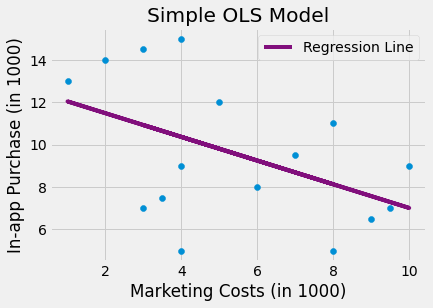

In [11]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

En connaissant beaucoup sur l'inférence causale, vous décidez de réaliser un modèle à effet fixe, en ajoutant l'indicateur de la ville comme variable muette dans votre modèle. Le modèle à effet fixe contrôle les caractéristiques spécifiques des villes qui sont constantes dans le temps, donc si une ville est moins réceptive à votre produit, cela sera pris en compte. Lorsque vous exécutez ce modèle, vous pouvez enfin constater que des coûts de marketing plus élevés entraînent une augmentation des achats in-app.

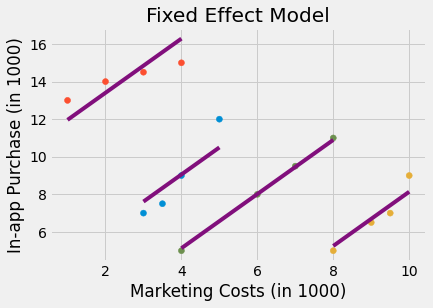

In [12]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Prenez un moment pour apprécier ce que l'image ci-dessus vous dit sur le rôle de l'effet fixe. Remarquez que l'effet fixe ajuste **une ligne de régression par ville**. Notez également que les lignes sont parallèles. La pente de la ligne représente l'effet des coûts de marketing sur les achats in-app. Ainsi, **l'effet fixe suppose que l'effet causal est constant pour toutes les entités**, qui sont les villes dans ce cas. Cela peut être une faiblesse ou un avantage, selon la manière dont vous l'interprétez. C'est une faiblesse si vous souhaitez trouver l'effet causal par ville. Comme le modèle à effet fixe suppose que cet effet est constant entre les entités, vous ne trouverez aucune différence dans l'effet causal. Cependant, si vous voulez connaître l'impact global du marketing sur les achats in-app, la structure en panel des données est un atout très utile que les effets fixes peuvent exploiter.

## Effets Temporels

De la même manière que nous avons appliqué un effet fixe au niveau individuel, nous pourrions concevoir un effet fixe pour le niveau temporel. Si l'ajout d'une variable muette pour chaque individu permet de contrôler les caractéristiques individuelles fixes, l'ajout d'une variable muette temporelle permettrait de contrôler les variables fixes pour chaque période, mais susceptibles de changer au fil du temps. Un exemple de ce type de variable est l'inflation. Les prix et les salaires ont tendance à augmenter avec le temps, mais l'inflation pour chaque période est la même pour toutes les entités. Pour donner un exemple plus concret, supposons que le mariage augmente avec le temps. Si le salaire et la proportion de mariages changent également avec le temps, alors le temps agirait comme un facteur de confusion. Puisque l'inflation fait également augmenter les salaires avec le temps, une partie de l'association positive que nous observons entre le mariage et le salaire serait simplement due au fait que les deux augmentent avec le temps. Pour corriger cela, nous pouvons ajouter une variable muette pour chaque période. Dans `linear models`, cela revient simplement à ajouter `TimeEffects` à notre formule et à définir `cluster_time` sur true.

In [13]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


Dans ce nouveau modèle, l'effet du mariage sur le salaire a diminué de manière significative, passant de `0,1147` à `0,0476`. Cependant, ce résultat reste significatif au niveau de 99%, donc on peut toujours s'attendre à une augmentation des revenus liée au mariage.

## Quand les Données de Panel ne Vous Seront pas Utiles

L'utilisation de données de panel et de modèles à effets fixes est un outil extrêmement puissant pour l'inférence causale. Lorsque vous n'avez pas de données aléatoires ni de bons instruments, l'effet fixe est aussi convaincant que possible pour l'inférence causale avec des données non expérimentales. Cependant, il est important de mentionner que ce n'est pas une panacée. Il existe des situations où même les données de panel ne vous aideront pas.

Le cas le plus évident est lorsque vous avez des facteurs de confusion qui changent avec le temps. Les effets fixes ne peuvent éliminer le biais que pour les attributs qui sont constants pour chaque individu. Par exemple, supposons que vous puissiez augmenter votre niveau d'intelligence en lisant des livres et en mangeant beaucoup de bonnes graisses. Cela vous amène à obtenir un emploi mieux rémunéré et une femme. L'effet fixe ne pourra pas éliminer ce biais dû à la confusion liée à l'intelligence non mesurée, car dans cet exemple, l'intelligence change avec le temps.

Un autre cas moins évident où l'effet fixe échoue est celui de la **causalité inversée**. Par exemple, supposons que ce ne soit pas le mariage qui cause une augmentation de salaire, mais que c'est le fait de gagner plus qui augmente vos chances de vous marier. Dans ce cas, il apparaîtra qu'ils ont une corrélation positive, mais les revenus viennent en premier. Ils changeraient avec le temps et dans la même direction, donc les effets fixes ne pourraient pas contrôler cela.

![img](./data/img/fixed-effects/time-travel.png)

## Idées Clés

Ici, nous avons vu comment utiliser des données de panel, c'est-à-dire des données où nous avons plusieurs mesures des mêmes individus sur plusieurs périodes. Dans ce cas, nous pouvons utiliser un modèle à effet fixe qui contrôle pour l'entité, en maintenant tous les attributs individuels et constants dans le temps, fixes. C'est une méthode puissante et très convaincante pour contrôler les facteurs de confusion, et c'est ce qui se fait de mieux avec des données non aléatoires.

Enfin, nous avons vu que l'effet fixe n'est pas une panacée. Nous avons identifié deux situations où il ne fonctionne pas : lorsque nous avons une causalité inversée et lorsque la confusion non mesurée change avec le temps.

## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).